# New sequence data generator

Depending on the batch size, the sequence data generator returns specified number of slices from each patient.

In [202]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt

##  Hyperparemeters

In [203]:
train_HGG_patients = 239
valid_HGG_patients = 20
image_size = 240
channels = 4
learning_rate = 5e-4
epochs = 200
batch_size = 10

## SequenceDataGenerator

The `SequenceDataGenerator` returns desired number of tensors (based on the batch\_size) as numpy array, where each tensor consists of 4 channels, each representing one of the imaging sequences acquired for every patient.

### Methods
`__init__` method initializes the _dir\_path array_ with all patients directories, based on inputs _mode_ and _glioma\_type_. 

`__normalise__` takes a tensor and normalises the brain region on each channel individually

`__get_images_masks__` loopes through directories and creates tensors

### Tumor regions and their codes
all: -1, edema: 1, non-enhancing: 2, enhancing: 3, necrosis: 4

In [206]:
class SequenceDataGenerator(keras.utils.Sequence):

    def __init__(self, 
                 batch_size, 
                 file_path='../dataset/', 
                 mode='training', 
                 glioma_type=['HGG'], 
                 tumor_region=-1, 
                 random_slices=False, 
                 slices_w_tumor_only=False,
                 slices_w_less_brain=None):
        
        self.dir_paths = []
        for glioma in glioma_type:
            for directory in os.listdir(file_path + mode + "/" + glioma):
                self.dir_paths.append(os.path.join(file_path, mode, glioma, directory))
        self.mode = mode
        self.batch_size = batch_size
        self.tumor_region = tumor_region
        self.random_slices = random_slices
        self.slices_w_tumor_only = slices_w_tumor_only
        self.slices_w_less_brain = slices_w_less_brain

    def __len__(self):
        return int(np.ceil(len(self.dir_paths) / float(self.batch_size)))
    
    def __get_image_array__(self, file_path):
            return sitka.GetArrayFromImage(sitka.ReadImage(file_path, sitka.sitkFloat32))
    
    def __normalise__(self, tensor):

        for idx_channel, channel in enumerate(tensor):

            b_rows, b_cols = np.nonzero(channel.astype(bool))
            brain_values = []
            for coords in zip(b_rows, b_cols):
                y, x = coords
                brain_values.append(channel[y][x])
            brain = np.array(brain_values)

            if np.count_nonzero(brain): # only normalise slices with a brain region
                b_mean = brain.mean()
                b_std = brain.std()
                if b_mean and b_std:
                    brain = (brain - b_mean) / b_std

            channel = np.zeros((image_size, image_size)) # Reset background
            for idx,coords in enumerate(zip(b_rows, b_cols)):
                y, x = coords
                channel[y, x] = brain[idx]
            
            tensor[idx_channel] = channel
            
        return tensor
    
    def __select_tumor_region__(self, mask):
        if self.tumor_region != -1: # only apply if specific labels are requested
            for i, channel in enumerate(mask):
                mask[i][mask[i] >= self.tumor_region] = self.tumor_region
                mask[i][mask[i] < self.tumor_region] = 0
        return mask
    
    def __get_slice_idxs_w_tumor(self, mask, num):     
        mask_idxs = []
        slice_offset = 40
        for i, s in enumerate(mask[slice_offset:]):
            if np.count_nonzero(s > 0) > self.slices_w_tumor_only:
                mask_idxs.append(i + slice_offset)
            if len(mask_idxs) == num:
                return mask_idxs

    def __get_images_masks__(self, patient_dir, batch_size):
        
        imaging_sequence_sufixes = ["_flair.nii", "_t1.nii", "_t1ce.nii", "_t2.nii"]
        mask_sufix = "_seg.nii"
        num_slices_per_image = 159
        # Slices with expected high ratio of brain campared with its background
        slices_from = 60
        slices_to = 100
        
        # Declare and initialize numpy arrays to return
        tensor = np.zeros((batch_size, len(imaging_sequence_sufixes), 240, 240))
        mask = np.zeros((batch_size, 1, 240, 240))
        
        # Open patients images
        mask_img = self.__get_image_array__(patient_dir + "/" + patient_dir[patient_dir.rfind('\\') + 1:] + mask_sufix)
        tensors = []
        for sufix in imaging_sequence_sufixes:
            tensors.append(self.__get_image_array__(patient_dir + "/" + patient_dir[patient_dir.rfind('\\') + 1:] + sufix))
        
        # Create field to iterate through
        slice_indexes = None
        if self.random_slices:
            slice_indexes = np.random.choice(range(slices_from, slices_to), self.batch_size, replace=False)
        else:
            # Fill numpy arrays with desired number of slices from patients images
            slice_indexes = list(range(int(num_slices_per_image / 2 - batch_size / 2), int(num_slices_per_image / 2 + batch_size / 2)))
        
        # include slices with less brain - picks 2 or given number of slices from range 30-60 and (or) 100-120
        if self.slices_w_less_brain:
            if type(self.slices_w_less_brain) == int and self.slices_w_less_brain > 0:
                for i in range(self.slices_w_less_brain):
                    slice_indexes[i] = random.randint(*random.choice([(slices_from-20, slices_from), (slices_to, slices_to+20)]))
        
        # if selected, replace all slices without tumor with slices that contain tumor
        if self.slices_w_tumor_only and self.mode == "training":
            indexes_w_tumor = self.__get_slice_idxs_w_tumor(mask_img, len(slice_indexes))
            for i, slice_i in enumerate(slice_indexes):
                if np.count_nonzero(mask_img[slice_i] > 0) < self.slices_w_tumor_only:
                    slice_indexes[i] = indexes_w_tumor[i]
            slice_indexes = indexes_w_tumor
        
        # Loop through slice indexes and fill values in to the "to be returned" tensor
        for final_tensor_i, slice_i in enumerate(slice_indexes):
            for tensors_i in range(len(imaging_sequence_sufixes)):
                tensor[final_tensor_i][tensors_i] = tensors[tensors_i][slice_i]
        
            mask[final_tensor_i] = mask_img[slice_i]
            
            # Normalise tensor
            tensor[final_tensor_i] = self.__normalise__(tensor[final_tensor_i])
            
        return tensor, mask

    def __getitem__(self, idx):
        
        patient_dir = self.dir_paths[idx:idx + 1] 
        return self.__get_images_masks__(patient_dir[0], self.batch_size)

TEST

In [207]:
gen = SequenceDataGenerator(batch_size=batch_size, mode="training", tumor_region=-1, random_slices=True, slices_w_tumor_only=500, slices_w_less_brain=2)
x, y = gen.__getitem__(152)
print(x.shape, y.shape)

(10, 4, 240, 240) (10, 1, 240, 240)


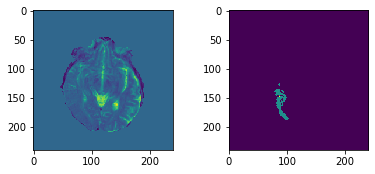

In [208]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[0][3])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y[0][0])

## U-Net

In [209]:
def conv_relu_block(input_tensor, num_of_filters):

    conv_relu = keras.layers.Conv2D(activation='relu',
                                    filters=num_of_filters,
                                    kernel_size=(3, 3),
                                    strides=1,
                                    padding='same',
                                    data_format='channels_first')(input_tensor)
    conv_relu = keras.layers.Conv2D(activation='relu',
                                    filters=num_of_filters,
                                    kernel_size=(3, 3),
                                    strides=1,
                                    padding='same',
                                    data_format='channels_first')(conv_relu)

    return conv_relu

In [210]:
def max_pool(input_tensor):
    return keras.layers.MaxPooling2D(pool_size=(2, 2),
                                     strides=None,
                                     padding='same',
                                     data_format='channels_first')(input_tensor)

In [211]:
def up_sample(input_tensor, encode_input_tensor):
    us = keras.layers.UpSampling2D(size=(2, 2),
                                   data_format='channels_first')(input_tensor)
    concat = keras.layers.Concatenate(axis=1)(inputs=[us, encode_input_tensor])
    return concat

In [212]:
def UNet():

    filters = [1, 64, 128, 256, 512, 1024]

    input_data = keras.layers.Input(shape=(channels, image_size, image_size))
    
    print(input_data.shape)

    # encode
    cr1 = conv_relu_block(input_data, filters[1])
    md1 = max_pool(cr1)
    cr2 = conv_relu_block(md1, filters[2])
    md2 = max_pool(cr2)
    cr3 = conv_relu_block(md2, filters[3])
    md3 = max_pool(cr3)
    cr4 = conv_relu_block(md3, filters[4])
    md4 = max_pool(cr4)

    # bottom
    cr5 = conv_relu_block(md4, filters[5])

    # decode
    us1 = up_sample(cr5, cr4)
    cr6 = conv_relu_block(us1, filters[4])
    us2 = up_sample(cr6, cr3)
    cr7 = conv_relu_block(us2, filters[3])
    us3 = up_sample(cr7, cr2)
    cr8 = conv_relu_block(us3, filters[2])
    us4 = up_sample(cr8, cr1)
    cr9 = conv_relu_block(us4, filters[1])

    output_data = keras.layers.Conv2D(filters=filters[0],
                                      kernel_size=(1, 1),
                                      padding="same",
                                      activation="sigmoid",
                                      data_format='channels_first')(cr9)

    model = keras.models.Model(input_data,
                               output_data,
                               name="UNet")

    return model

In [243]:
model = UNet()
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )

(None, 4, 240, 240)


In [244]:
callbacks = [
    keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=25, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
]

In [215]:
train_gen = SequenceDataGenerator(batch_size=batch_size, 
                                  mode="training", 
                                  random_slices=None, 
                                  slices_w_less_brain=None, 
                                  slices_w_tumor_only=500)
valid_gen = SequenceDataGenerator(batch_size=batch_size, 
                                  mode="validation",
                                  random_slices=None, 
                                  slices_w_less_brain=None, 
                                  Sslices_w_tumor_only=500)

train_steps = train_HGG_patients
valid_steps = valid_HGG_patients

hist = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, shuffle=True, callbacks=callbacks)

model.save("../models/2020032600.h5")

Epoch 1/200
239/239 [==============================] - 357s 1s/step - loss: 51.9835 - accuracy: 0.0490 - val_loss: 33.6567 - val_accuracy: 0.0044
Epoch 2/200
239/239 [==============================] - 357s 1s/step - loss: 47.2410 - accuracy: 0.0571 - val_loss: 22.5237 - val_accuracy: 0.0058
Epoch 3/200
239/239 [==============================] - 355s 1s/step - loss: 49.0491 - accuracy: 0.1030 - val_loss: 32.5217 - val_accuracy: 0.0264
Epoch 4/200
239/239 [==============================] - 355s 1s/step - loss: 47.7468 - accuracy: 0.0469 - val_loss: 23.6542 - val_accuracy: 0.0296
Epoch 5/200
239/239 [==============================] - 369s 2s/step - loss: 46.6549 - accuracy: 0.0419 - val_loss: 30.8519 - val_accuracy: 0.0173
Epoch 6/200
239/239 [==============================] - 355s 1s/step - loss: 30.6329 - accuracy: 0.3179 - val_loss: 7.7466e-07 - val_accuracy: 0.7234
Epoch 7/200
239/239 [==============================] - 351s 1s/step - loss: 1.5569e-06 - accuracy: 0.7711 - val_loss: 8.8

In [242]:
print(hist.history['val_loss'])

[33.65667724609375, 22.523740768432617, 32.521697998046875, 23.654186248779297, 30.85188865661621, 7.746617711745785e-07, 8.86867610461195e-07, 7.364155294453667e-07, 1.106957824958954e-06, 7.874767788962345e-07, 1.0031463943960262e-06, 1.0149183253815863e-06, 1.0760627446870785e-06, 1.0674200439098058e-06, 7.444124889843806e-07, 8.204581263271393e-07, 7.865828024478105e-07, 1.038611117110122e-06, 8.934737252275227e-07, 8.080900784079859e-07, 5.891919840905757e-07, 7.205209726635076e-07, 9.93907633528579e-07, 9.170673251901462e-07, 8.296472060465021e-07, 1.2571614433909417e-06, 1.0994078820658615e-06, 1.2631716117539327e-06, 6.632507734138926e-07, 9.800495490708272e-07, 1.1443099765529041e-06]


### Results

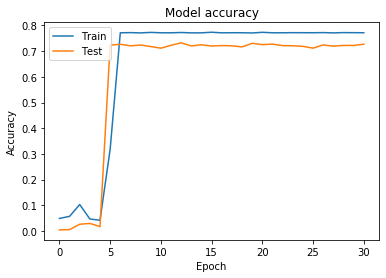

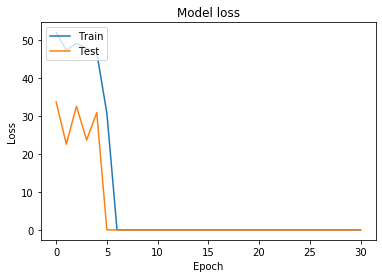

In [216]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [239]:
x, y = valid_gen.__getitem__(random.randint(0, 19))
pred = model.predict(x)

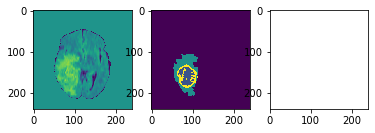

In [240]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x[0][0]) #, cmap='gray', vmin=0
axarr[1].imshow(y[0][0]) #, cmap='gray', vmin=0
axarr[2].imshow(pred[0][0]) #, cmap='gray', vmin=0

In [80]:
model.save("../models/2020032501.h5")